In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from pandas import ExcelWriter
from pandas import ExcelFile
from geopy.geocoders import Nominatim
import re
%matplotlib inline

initial_data = pd.read_csv('properties_2017.csv')
zillow_total_log = pd.read_csv('train_2016_v2.csv')
zillow_total_log_2 = pd.read_csv('train_2017.csv')
initial_data_2 = pd.concat([zillow_total_log,zillow_total_log_2], axis=0)
total_data = pd.merge(initial_data, initial_data_2, how = 'right', on = 'parcelid')

/home/vaibhav/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/vaibhav/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
#Filling the missing values 
features = ['bathroomcnt','finishedsquarefeet12','yearbuilt', 
            'structuretaxvaluedollarcnt','landtaxvaluedollarcnt', 'regionidcounty']
q1_data = total_data[features]
q1_data = q1_data.dropna(how='all')
grouped_col = q1_data.groupby("regionidcounty")
q1_data['yearbuilt'] = grouped_col.yearbuilt.transform(lambda x: x.fillna(x.mode()[0]))
q1_data['bathroomcnt'] = grouped_col.bathroomcnt.transform(lambda x: x.fillna(x.mode()[0]))
q1_data['finishedsquarefeet12'] = grouped_col.finishedsquarefeet12.transform(lambda x: x.fillna(x.mode()[0]))
q1_data['structuretaxvaluedollarcnt'] = grouped_col.structuretaxvaluedollarcnt.transform(lambda x: x.fillna(x.mean()))
q1_data['landtaxvaluedollarcnt'] = grouped_col.landtaxvaluedollarcnt.transform(lambda x: x.fillna(x.mean()))
q1_data['yearbuilt'] = 2017 - q1_data['yearbuilt']
q1_data['finishedsquarefeet12'] = np.log(q1_data['finishedsquarefeet12'])
q1_data['structuretaxvaluedollarcnt'] = np.log(q1_data['structuretaxvaluedollarcnt'])
q1_data['landtaxvaluedollarcnt'] = np.log(q1_data['landtaxvaluedollarcnt'])

In [6]:
from sklearn import preprocessing
minn = 1
maxx = 10
min_max_scaler = preprocessing.MinMaxScaler(feature_range =(minn, maxx))

bathroomcnt_x = q1_data.bathroomcnt.values.reshape(-1,1) #returns a numpy array
finishedsquarefeet12_x = q1_data.finishedsquarefeet12.values.reshape(-1,1) #returns a numpy array
structuretaxvaluedollarcnt_x = q1_data.structuretaxvaluedollarcnt.values.reshape(-1,1) #returns a numpy array
landtaxvaluedollarcnt_x = q1_data.landtaxvaluedollarcnt.values.reshape(-1,1) #returns a numpy array

bathroomcnt_x_scaled = min_max_scaler.fit_transform(bathroomcnt_x)
finishedsquarefeet12_x_scaled = min_max_scaler.fit_transform(finishedsquarefeet12_x)
structuretaxvaluedollarcnt_x_scaled = min_max_scaler.fit_transform(structuretaxvaluedollarcnt_x)
landtaxvaluedollarcnt_x_scaled = min_max_scaler.fit_transform(landtaxvaluedollarcnt_x)

q1_data.bathroomcnt = bathroomcnt_x_scaled
q1_data.finishedsquarefeet12 = finishedsquarefeet12_x_scaled
q1_data.structuretaxvaluedollarcnt = structuretaxvaluedollarcnt_x_scaled
q1_data.landtaxvaluedollarcnt = landtaxvaluedollarcnt_x_scaled

In [7]:
def normalizeyears(x):
    if x <= 7 and x >= 0:
        return 10
    elif x > 7 and x <= 17:
        return 7
    elif x > 17 and x <= 80:
        return 5
    elif x > 80 and x <= 90:
        return 8
    elif x > 90 and x <= 100:
        return 9
    elif x >100:
        return 10
def countynormalize(x):
    # fn = 200/(1+ 10*VC + PC)
    #Ventura = 2061
    #VC = 2.3 and PC = 20.1
    #LA = 3101
    #VC = 4.3 and PC = 21.8
    #Orange = 1286
    #VC = 2.0 and PC = 17.7
    if x == 2061:
        r = 4.535
    elif x == 3101:
        r = 3.03
    #Orange
    elif x == 1286:
        r = 5.16
    return r    

In [8]:
yearbuilt_series = q1_data.yearbuilt.apply(normalizeyears)
q1_data.yearbuilt = yearbuilt_series.to_frame(name= 'yearbuilt')

regionidcounty_series = q1_data.regionidcounty.apply(countynormalize)
q1_data.regionidcounty = regionidcounty_series.to_frame(name= 'regionidcounty')

In [9]:
def scoringfunction(row):
    denominator = np.log2(row.structuretaxvaluedollarcnt) * np.log2(row.landtaxvaluedollarcnt)
    result = (row.bathroomcnt * np.log2(row.finishedsquarefeet12) * row.regionidcounty * np.sqrt(row.yearbuilt) ) 
    / np.sqrt(denominator)
    return result

In [10]:
q1_data['score'] = q1_data.apply(scoringfunction, axis = 1)
sorted_by_score = q1_data.sort_values(by = 'score', ascending=False)
sorted_by_score.head()

,bathroomcnt,finishedsquarefeet12,yearbuilt,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,regionidcounty,score
61989,5.725,9.236522,10,9.191004,8.531154,5.16,299.620487
61988,5.050,9.236522,10,9.180338,8.521834,5.16,264.294054
198093,9.100,9.843509,8,6.507387,10.000000,3.03,257.296610
198092,9.100,9.843509,8,6.496727,9.990680,3.03,257.296610
119979,4.825,8.952119,10,8.826954,8.538392,5.16,248.966185


In [11]:
q1_data.iloc[0:100,:]

,bathroomcnt,finishedsquarefeet12,yearbuilt,structuretaxvaluedollarcnt,landtaxvaluedollarcnt,regionidcounty,score
0,3.250,8.293936,5,7.572626,6.984008,4.535,100.586173
1,3.250,8.293936,5,7.583290,6.993327,4.535,100.586173
2,1.900,7.368046,5,6.625208,6.864140,4.535,55.513891
3,1.900,7.368046,5,6.635866,6.873458,4.535,55.513891
4,1.675,7.524812,5,6.900606,6.133413,4.535,49.455786
5,1.675,7.524812,5,6.911271,6.142721,4.535,49.455786
6,2.125,7.239238,5,6.545435,6.022975,4.535,61.539617
7,2.125,7.239238,5,6.556094,6.032287,4.535,61.539617
8,1.900,6.998933,5,6.364292,6.498227,4.535,54.085294
9,1.900,6.998933,5,6.374955,6.507545,4.535,54.085294


In [12]:
distance_columns = ['latitude', 'longitude', 'bathroomcnt', 'regionidcounty', 'regionidzip', 'propertylandusetypeid']
q2_data = total_data[distance_columns]
q2_data = q2_data.dropna(how='all')
q2_data['regionidzip'] = q2_data['regionidzip'].fillna(q2_data['regionidzip'].mode()[0])
q2_data.head()
# euclidean_distances(q2_data, q2_data)

,latitude,longitude,bathroomcnt,regionidcounty,regionidzip,propertylandusetypeid
0,34449407.0,-119254052.0,5.0,2061.0,97099.0,261.0
1,34449407.0,-119254052.0,5.0,2061.0,97099.0,261.0
2,34454169.0,-119237898.0,2.0,2061.0,97099.0,261.0
3,34454169.0,-119237898.0,2.0,2061.0,97099.0,261.0
4,34365693.0,-119448392.0,1.5,2061.0,97081.0,261.0


In [16]:
reduced_data = PCA(n_components=2).fit_transform(q2_data)
kmeans = KMeans(n_clusters=10, random_state=0).fit(reduced_data)
labels = kmeans.predict(reduced_data)
q2_data.loc[:, 'label'] = kmeans.labels_
centroids = kmeans.cluster_centers_

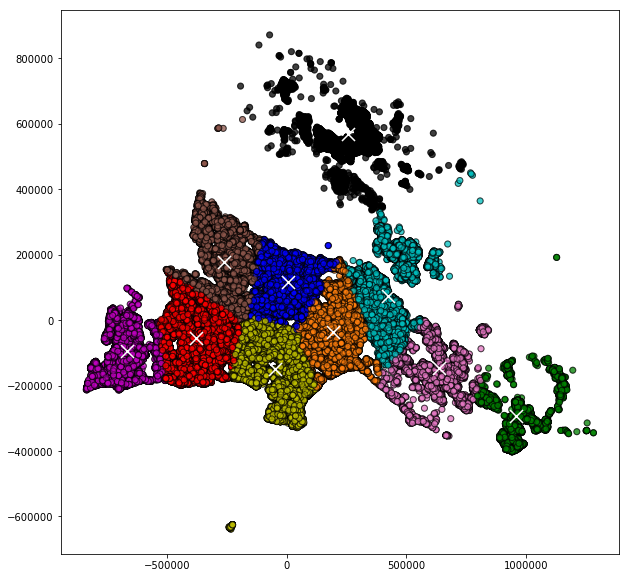

In [17]:
fig = plt.figure(figsize=(10, 10))
colmap = {1: 'r', 2: 'g', 3: 'b', 4: 'c', 5: 'm', 6: 'y',7:'k',8:'tab:orange',9:'tab:brown',10:'tab:pink'}

# colors = map(lambda x: colmap[x+1], labels)
colors = [colmap[x+1] for x in labels]
plt.scatter(reduced_data[:,0], reduced_data[:,1], c=colors, alpha=0.5, edgecolor='k')
for idx, centroid in enumerate(centroids):
    plt.scatter(*centroid, c='w', marker='x',zorder=10, s=170)
plt.show()

In [27]:
#Question 4

q4_data = total_data
q4_data = q4_data.reindex(columns = np.append(q4_data.columns.values, ['Geopy_Zip']))

#evaluate zip codes from geopy
df_zip = q4_data[['latitude', 'longitude','regionidzip','Geopy_Zip']]
df_zip = df_zip.drop_duplicates('regionidzip')

# #Finding Zips
geolocator = Nominatim()
def findDefault(address):
    county = address['county']
    if(county == "Los Angeles County"):
        zip = [11111]
        return zip
    elif(county == "Orange County"):
        zip = [22222]
        return zip
    elif(county == "Ventura County"):
        zip = [33333]
        return zip

def findZip(latlong):
    location = geolocator.reverse(latlong)
    zipID = 0
    if("postcode" in location.raw['address']):
        zipID = [int(s) for s in re.findall(r'\b\d+\b', location.raw['address']['postcode'])]
    else:
        zipID = findDefault(location.raw['address'])
        if(len(zipID) == 0):
            zipID = findDefault(location.raw['address'])
    return zipID[0]

for index, row in df_zip.iterrows():
    lat = ((row['latitude'])/1000000)
    lat = str(lat)
    long = ((row['longitude'])/1000000)
    long = str(long)
    val = lat + ',' + long
    zipID = findZip(val)
    row['Geopy_Zip'] = zipID

In [29]:
# #Populating q3_data
q4_data.Geopy_Zip = q4_data.Geopy_Zip.astype(float)

for index, row in q4_data.iterrows():
    if(np.isnan(row['regionidzip']) == False):
        zipid = row['regionidzip']
        val = df_zip.loc[df_zip['regionidzip'] == zipid, 'Geopy_Zip'].iloc[0]
        q4_data.loc[index, 'Geopy_Zip'] = val
#     else:
#         lat = ((row['latitude'])/1000000)
#         lat = str(lat)
#         long = ((row['longitude'])/1000000)
#         long = str(long)
#         val = lat + ',' + long
#         zipID = findZip(val)
#         q4_data.loc[index, 'Geopy_Zip'] = zipID

# q4_data.loc[q4_data['Geopy_Zip'] == 11111,'Geopy_Zip'] = np.nan
# q4_data.loc[q4_data['Geopy_Zip'] == 22222,'Geopy_Zip'] = np.nan
# q4_data.loc[q4_data['Geopy_Zip'] == 33333,'Geopy_Zip'] = np.nan

# #Populating empty ZIP's with mode
# q4_data_part = q4_data[['regionidcounty', 'Geopy_Zip']]
# grouped_col = q4_data_part.groupby("regionidcounty")
# q4_data['Geopy_Zip'] = grouped_col.Geopy_Zip.transform(lambda x: x.fillna(x.mode()[0]))

# #Adding new column School Count
# q4_data = q4_data.reindex(columns = np.append(q4_data.columns.values, ['School_Count']))

# #Reading excel file for Schools with Zip Code
# school_df = pd.read_excel('school_list_filtered.xls')
# school_df_filtered = school_df[school_df.County.str.startswith(('Los Angeles', 'Orange', 'Ventura'))]
# #remove Nan values for Zip
# school_df_filtered = school_df_filtered[school_df_filtered.Zip.notnull()]
# df_school = (school_df_filtered.Zip.value_counts()).to_frame().reset_index()
# df_school.columns = ['regionidzip', 'zipcount']

# #Integrating the data of School Count with Zip Code
# #total_data.School_Count = total_data.School_Count.astype(int)
# for index, row in q4_data.iterrows():
#     if(np.isnan(row['School_Count']) == True):
#         zipid = row['Geopy_Zip']
#         if((len(df_school.loc[df_school['regionidzip'] == zipid, 'zipcount']) > 0)):
#             val = df_school.loc[df_school['regionidzip'] == zipid, 'zipcount'].iloc[0]
#             q4_data.loc[index, 'School_Count'] = val

# #Writing CSV file
# q4_data.to_csv('total_data_with_school_count.csv')

In [35]:
for index, row in q4_data.iterrows():
    if(np.isnan(row['regionidzip']) == False):
        lat = ((row['latitude'])/1000000)
        lat = str(lat)
        long = ((row['longitude'])/1000000)
        long = str(long)
        val = lat + ',' + long
        print(val)
        zipID = findZip(val)
        print(zipID)
        q4_data.loc[index, 'Geopy_Zip'] = zipID
# from geopy.geocoders import Nominatim
# geolocator = Nominatim()
# location = geolocator.reverse("33.776600, -117.914000")
# p = location.address
# location.raw

GeocoderServiceError: HTTP Error 429: Too Many Requests

In [52]:
#creating HashMap

q4_hash_data = pd.read_csv('total_data_with_school_count.csv')

#Create a Dictionary

df_temp = q4_hash_data[['Geopy_Zip', 'School_Count']]

ZiptoSchool = {}
for index, row in df_temp.iterrows():
    zipID =  row['Geopy_Zip']
    SchoolData = row['School_Count']
    ZiptoSchool[zipID] = SchoolData

df_temp = q4_hash_data[['regionidzip', 'Geopy_Zip']]

KZiptoActualZip = {}
for index, row in df_temp.iterrows():
    KZip = row['regionidzip']
    zipID = row['Geopy_Zip']
    if(np.isnan(KZip) == False):
        KZiptoActualZip[KZip] = zipID

93023.0


In [53]:
import json
with open('ZiptoSchool.json', 'w') as fp:
    json.dump(ZiptoSchool, fp)
with open('KZiptoActualZip.json', 'w') as fp:
    json.dump(KZiptoActualZip, fp)

In [73]:
with open('ZiptoSchool.json', 'r') as fp:
    SchoolZip = json.load(fp)
with open('KZiptoActualZip.json', 'r') as fp:
    KToActualZip = json.load(fp)

{'399675.0': 91010.0,
 '95982.0': 90001.0,
 '95983.0': 90002.0,
 '95984.0': 90003.0,
 '95985.0': 90028.0,
 '95986.0': 90005.0,
 '95987.0': 90006.0,
 '95988.0': 90007.0,
 '95989.0': 90062.0,
 '95991.0': 90028.0,
 '95992.0': 90011.0,
 '95993.0': 90012.0,
 '95994.0': 90015.0,
 '95995.0': 90014.0,
 '95996.0': 90015.0,
 '95997.0': 90016.0,
 '95998.0': 90007.0,
 '95999.0': 90018.0,
 '96000.0': 90019.0,
 '96001.0': 90005.0,
 '96002.0': 90021.0,
 '96003.0': 90022.0,
 '96004.0': 90023.0,
 '96005.0': 90025.0,
 '96006.0': 90067.0,
 '96007.0': 90012.0,
 '96008.0': 90012.0,
 '96009.0': 90028.0,
 '96010.0': 90012.0,
 '96012.0': 90031.0,
 '96013.0': 5533.0,
 '96014.0': 90033.0,
 '96015.0': 90034.0,
 '96016.0': 90035.0,
 '96017.0': 90028.0,
 '96018.0': 90037.0,
 '96019.0': 90028.0,
 '96020.0': 91204.0,
 '96021.0': 90040.0,
 '96022.0': 90041.0,
 '96023.0': 90031.0,
 '96024.0': 90304.0,
 '96025.0': 90044.0,
 '96026.0': 90045.0,
 '96027.0': 90028.0,
 '96028.0': 90047.0,
 '96029.0': 90211.0,
 '96030.0': 9

In [79]:
def findZiptoSchoolCount(zipID):
    zipID = str(zipID)
    if(zipID in SchoolZip):
        return SchoolZip[zipID]
    else:
        return -1

def findActualZipfromKZip(zipID):
    zipID = str(zipID)
    if(zipID in KToActualZip):
        return KToActualZip[zipID]
    else:
        return -1

93023.0